<a href="https://colab.research.google.com/github/MerkulovDaniil/optim/blob/master/assets/Notebooks/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy --quiet
!pip install tensorflow --quiet
!pip install pandas --quiet
!pip install keras --quiet
!pip install d2l --quiet

     |████████████████████████████████| 83 kB 1.2 MB/s 


In [ ]:
%matplotlib inline
from d2l import torch as d2l
from torch import nn
import torch
import torchvision
import os

# 🧬🎲➰ Generative Adversarial Networks

Throughout most of this book, we have talked about how to make predictions. In some form or another, we used deep neural networks learned mappings from data examples to labels. This kind of learning is called discriminative learning, as in, we'd like to be able to discriminate between photos cats and photos of dogs. Classifiers and regressors are both examples of discriminative learning. And neural networks trained by backpropagation have upended everything we thought we knew about discriminative learning on large complicated datasets. Classification accuracies on high-res images has gone from useless to human-level (with some caveats) in just 5-6 years. We will spare you another spiel about all the other discriminative tasks where deep neural networks do astoundingly well.

But there is more to machine learning than just solving discriminative tasks. For example, given a large dataset, without any labels, we might want to learn a model that concisely captures the characteristics of this data. Given such a model, we could sample synthetic data examples that resemble the distribution of the training data. For example, given a large corpus of photographs of faces, we might want to be able to generate a new photorealistic image that looks like it might plausibly have come from the same dataset. This kind of learning is called generative modeling.

Until recently, we had no method that could synthesize novel photorealistic images. But the success of deep neural networks for discriminative learning opened up new possibilities. One big trend over the last three years has been the application of discriminative deep nets to overcome challenges in problems that we do not generally think of as supervised learning problems. The recurrent neural network language models are one example of using a discriminative network (trained to predict the next character) that once trained can act as a generative model.

In 2014, a breakthrough paper introduced Generative adversarial networks (GANs) :cite:`Goodfellow.Pouget-Abadie.Mirza.ea.2014`, a clever new way to leverage the power of discriminative models to get good generative models. At their heart, GANs rely on the idea that a data generator is good if we cannot tell fake data apart from real data. In statistics, this is called a two-sample test - a test to answer the question whether datasets $X=\{x_1,\ldots, x_n\}$ and $X'=\{x'_1,\ldots, x'_n\}$ were drawn from the same distribution. The main difference between most statistics papers and GANs is that the latter use this idea in a constructive way. In other words, rather than just training a model to say "hey, these two datasets do not look like they came from the same distribution", they use the [two-sample test](https://en.wikipedia.org/wiki/Two-sample_hypothesis_testing) to provide training signals to a generative model. This allows us to improve the data generator until it generates something that resembles the real data. At the very least, it needs to fool the classifier. Even if our classifier is a state of the art deep neural network.

![Generative Adversarial Networks](http://d2l.ai/_images/gan.svg)

The GAN architecture is illustrated in :numref:`fig_gan`.
As you can see, there are two pieces in GAN architecture - first off, we need a device (say, a deep network but it really could be anything, such as a game rendering engine) that might potentially be able to generate data that looks just like the real thing. If we are dealing with images, this needs to generate images. If we are dealing with speech, it needs to generate audio sequences, and so on. We call this the generator network. The second component is the discriminator network. It attempts to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator network. At that point, the discriminator network adapts to the new fake data. This information, in turn is used to improve the generator network, and so on.


The discriminator is a binary classifier to distinguish if the input $x$ is real (from real data) or fake (from the generator). Typically, the discriminator outputs a scalar prediction $o\in\mathbb R$ for input $\mathbf x$, such as using a dense layer with hidden size 1, and then applies sigmoid function to obtain the predicted probability $D(\mathbf x) = 1/(1+e^{-o})$. Assume the label $y$ for the true data is $1$ and $0$ for the fake data. We train the discriminator to minimize the cross-entropy loss, *i.e.*,

$$ \min_D \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \},$$

For the generator, it first draws some parameter $\mathbf z\in\mathbb R^d$ from a source of randomness, *e.g.*, a normal distribution $\mathbf z \sim \mathcal{N} (0, 1)$. We often call $\mathbf z$ as the latent variable.
It then applies a function to generate $\mathbf x'=G(\mathbf z)$. The goal of the generator is to fool the discriminator to classify $\mathbf x'=G(\mathbf z)$ as true data, *i.e.*, we want $D( G(\mathbf z)) \approx 1$.
In other words, for a given discriminator $D$, we update the parameters of the generator $G$ to maximize the cross-entropy loss when $y=0$, *i.e.*,

$$ \max_G \{ - (1-y) \log(1-D(G(\mathbf z))) \} = \max_G \{ - \log(1-D(G(\mathbf z))) \}.$$

If the generator does a perfect job, then $D(\mathbf x')\approx 1$ so the above loss near 0, which results the gradients are too small to make a good progress for the discriminator. So commonly we minimize the following loss:

$$ \min_G \{ - y \log(D(G(\mathbf z))) \} = \min_G \{ - \log(D(G(\mathbf z))) \}, $$

which is just feed $\mathbf x'=G(\mathbf z)$ into the discriminator but giving label $y=1$.


To sum up, $D$ and $G$ are playing a "minimax" game with the comprehensive objective function:

$$min_D max_G \{ -E_{x \sim \text{Data}} log D(\mathbf x) - E_{z \sim \text{Noise}} log(1 - D(G(\mathbf z))) \}.$$



Many of the GANs applications are in the context of images. As a demonstration purpose, we are going to content ourselves with fitting a much simpler distribution first. We will illustrate what happens if we use GANs to build the world's most inefficient estimator of parameters for a Gaussian. Let us get started.


In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn

## Generate some "real" data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian.


In [ ]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

Let us see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^TA$.


The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


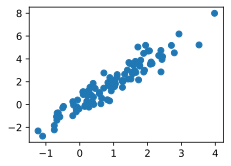

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100,
                                                       (1)].detach().numpy())
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [ ]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

## Generator

Our generator network will be the simplest network possible - a single layer linear model. This is since we will be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly.


In [ ]:
net_G = nn.Sequential(nn.Linear(2, 2))

## Discriminator

For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting.


In [ ]:
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

## Training

First we define a function to update the discriminator.


In [ ]:
#@save
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) + 
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

The generator is updated similarly. Here we reuse the cross-entropy loss but change the label of the fake data from $0$ to $1$.


In [ ]:
#@save
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.


In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

Now we specify the hyperparameters to fit the Gaussian distribution.


loss_D 0.693, loss_G 0.695, 1953.1 examples/sec


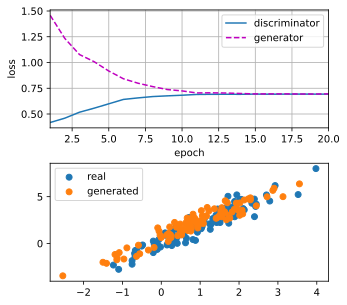

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim,
      data[:100].detach().numpy())

## Summary

* Generative adversarial networks (GANs) composes of two deep networks, the generator and the discriminator.
* The generator generates the image as much closer to the true image as possible to fool the discriminator, via maximizing the cross-entropy loss, *i.e.*, $\max \log(D(\mathbf{x'}))$.
* The discriminator tries to distinguish the generated images from the true images, via minimizing the cross-entropy loss, *i.e.*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.


# 🚀🖼🏂 Deep Convolutional GAN

In previous section, we introduced the basic ideas behind how GANs work. We showed that they can draw samples from some simple, easy-to-sample distribution, like a uniform or normal distribution, and transform them into samples that appear to match the distribution of some dataset. And while our example of matching a 2D Gaussian distribution got the point across, it is not especially exciting.

In this section, we will demonstrate how you can use GANs to generate photorealistic images. We will be basing our models on the deep convolutional GANs (DCGAN) introduced in :cite:`Radford.Metz.Chintala.2015`. We will borrow the convolutional architecture that have proven so successful for discriminative computer vision problems and show how via GANs, they can be leveraged to generate photorealistic images.


In [ ]:
from d2l import torch as d2l
import torch
import torchvision
from torch import nn
import warnings

## The Pokemon Dataset

The dataset we will use is a collection of Pokemon sprites obtained from [pokemondb](https://pokemondb.net/sprites). First download, extract and load this dataset.


In [ ]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while our generator will use the tanh function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with $0.5$ mean and $0.5$ standard deviation to match the value range.


In [ ]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

Let us visualize the first 20 images.


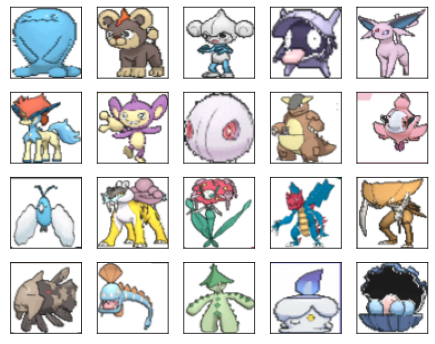

In [ ]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

## The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$ . In :numref:`sec_fcn` we introduced the fully convolutional network that uses transposed convolution layer (refer to :numref:`sec_transposed_conv`) to enlarge input size. The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.


In [ ]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In default, the transposed convolution layer uses a $k_h = k_w = 4$ kernel, a $s_h = s_w = 2$ strides, and a $p_h = p_w = 1$ padding. With a input shape of $n_h^{'} \times n_w^{'} = 16 \times 16$, the generator block will double input's width and height.

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$


In [ ]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

If changing the transposed convolution layer to a $4\times 4$ kernel, $1\times 1$ strides and zero padding. With a input size of $1 \times 1$, the output will have its width and height increased by 3 respectively.


In [ ]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.


In [ ]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3, 
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

Generate a 100 dimensional latent variable to verify the generator's output shape.


In [ ]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.


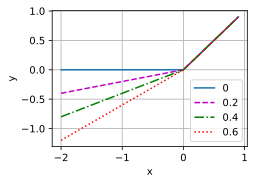

In [ ]:
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block.


In [ ]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

A basic block with default settings will halve the width and height of the inputs, as we demonstrated in :numref:`sec_padding`. For example, given a input shape $n_h = n_w = 16$, with a kernel shape $k_h = k_w = 4$, a stride shape $s_h = s_w = 2$, and a padding shape $p_h = p_w = 1$, the output shape will be:

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}
$$


In [ ]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

The discriminator is a mirror of the generator.


In [ ]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.


In [ ]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

## Training

Compared to the basic GAN in :numref:`sec_basic_gan`, we use the same learning rate for both generator and discriminator since they are similar to each other. In addition, we change $\beta_1$ in Adam (:numref:`sec_adam`) from $0.9$ to $0.5$. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other. Besides, the random generated noise `Z`, is a 4-D tensor and we are using GPU to accelerate the computation.


In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

We train the model with a small number of epochs just for demonstration.
For better performance,
the variable `num_epochs` can be set to a larger number.


loss_D 0.100, loss_G 8.246, 533.4 examples/sec on cuda:0


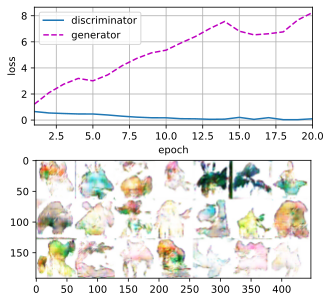

In [ ]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

## Summary

* DCGAN architecture has four convolutional layers for the Discriminator and four "fractionally-strided" convolutional layers for the Generator.
* The Discriminator is a 4-layer strided convolutions with batch normalization (except its input layer) and leaky ReLU activations.
* Leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the “dying ReLU” problem and helps the gradients flow easier through the architecture.

## Keras

We want to make machine learning and data analysis like this in the future:

```python
import autokeras as ak

clf = ak.ImageClassifier()
clf.fit(x_train, y_train)
results = clf.predict(x_test)
```

😀))000)))

# 🤖🧠💀 Autokeras

[source](https://autokeras.com/tutorial/overview/)

In [ ]:
!pip install autokeras

## A Simple Example
The first step is to prepare your data. Here we use the MNIST dataset as an example


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import autokeras as ak

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)


(60000, 28, 28)
(60000,)
[5 0 4]


In [ ]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


The second step is to run the ImageClassifier.
It is recommended have more trials for more complicated datasets.
This is just a quick demo of MNIST, so we set max_trials to 1.
For the same reason, we set epochs to 10.
You can also leave the epochs unspecified for an adaptive number of epochs.


In [ ]:
# Initialize the image classifier.
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)


# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))


Trial 1 Complete [00h 01m 19s]
val_loss: 0.04011617973446846

Best val_loss So Far: 0.04011617973446846
Total elapsed time: 00h 01m 19s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3012 - accuracy: 0.9071
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0781 - accuracy: 0.9759
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0648 - accuracy: 0.9801
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0534 - accuracy: 0.9835
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0473 - accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0419 - accuracy: 0.9865
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0386 - accuracy: 0.9878
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0356 - accuracy: 0.9885
Epoch 9/10

## Validation Data
By default, AutoKeras use the last 20% of training data as validation data. As shown in
the example below, you can use validation_split to specify the percentage.


In [ ]:
clf.fit(
    x_train,
    y_train,
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
    epochs=10,
)


In [ ]:
split = 50000
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]
clf.fit(
    x_train,
    y_train,
    # Use your own validation set.
    validation_data=(x_val, y_val),
    epochs=10,
)


## Customized Search Space
For advanced users, you may customize your search space by using AutoModel instead of
ImageClassifier. You can configure the ImageBlock for some high-level configurations,
e.g., block_type for the type of neural network to search, normalize for whether to do
data normalization, augment for whether to do data augmentation. You can also do not
specify these arguments, which would leave the different choices to be tuned
automatically. See the following example for detail.


In [ ]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="resnet",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=False,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=1)
clf.fit(x_train, y_train, epochs=10)


The usage of AutoModel is similar to the functional API of Keras. Basically, you are
building a graph, whose edges are blocks and the nodes are intermediate outputs of
blocks. To add an edge from input_node to output_node with output_node =
ak.[some_block]([block_args])(input_node).

You can even also use more fine grained blocks to customize the search space even
further. See the following example.


In [ ]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageAugmentation(horizontal_flip=False)(output_node)
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=1)
clf.fit(x_train, y_train, epochs=2)


Trial 1 Complete [00h 02m 59s]
val_loss: 0.1333337426185608

Best val_loss So Far: 0.1333337426185608
Total elapsed time: 00h 02m 59s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
1563/1563 [==============================] - 103s 60ms/step - loss: 0.5831 - accuracy: 0.8263
Epoch 2/2
1563/1563 [==============================] - 94s 60ms/step - loss: 0.2448 - accuracy: 0.9385
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


## Data Format
The AutoKeras ImageClassifier is quite flexible for the data format.

For the image, it accepts data formats both with and without the channel dimension. The
images in the MNIST dataset do not have the channel dimension. Each image is a matrix
with shape (28, 28). AutoKeras also accepts images of three dimensions with the channel
dimension at last, e.g., (32, 32, 3), (28, 28, 1).

For the classification labels, AutoKeras accepts both plain labels, i.e. strings or
integers, and one-hot encoded encoded labels, i.e. vectors of 0s and 1s.

So if you prepare your data in the following way, the ImageClassifier should still work.


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the images to have the channel dimension.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# One-hot encode the labels.
eye = np.eye(10)
y_train = eye[y_train]
y_test = eye[y_test]

print(x_train.shape)  # (60000, 28, 28, 1)
print(y_train.shape)  # (60000, 10)
print(y_train[:3])
# array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
#        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
#        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


(60000, 28, 28, 1)
(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


We also support using tf.data.Dataset format for the training data.


In [ ]:
train_set = tf.data.Dataset.from_tensor_slices(((x_train,), (y_train,)))
test_set = tf.data.Dataset.from_tensor_slices(((x_test,), (y_test,)))

clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1)
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=10)
# Predict with the best model.
predicted_y = clf.predict(test_set)
# Evaluate the best model with testing data.
print(clf.evaluate(test_set))


Trial 1 Complete [00h 01m 25s]
val_loss: 0.03724956139922142

Best val_loss So Far: 0.03724956139922142
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3004 - accuracy: 0.9089
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0816 - accuracy: 0.9754
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0622 - accuracy: 0.9807
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0543 - accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0475 - accuracy: 0.9855
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0412 - accuracy: 0.9875
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0373 - accuracy: 0.9883
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0363 - accuracy: 0.9882
Epoch 9/10

# Questions (optional)

1. Explain an intuition of style and content loss.
2. Tell about fine-tuning in your own words.
3. How do you explain GAN to a child.
4. Write five applications of GAN and Style Transfer? Explain what is the benefit of using GAN and ST in these tasks.
5. Is it possible to do Style Transfer, when content and style have different sizes? Why yes or not?
6. How to use Style Transfer with 2 styles?
7. What modifications can make GAN training more robust? How?

If you don't know some answer for questions above, try to find them in the Internet.